### Assignment 1

Submission should be in a Jupyter note book (.ipynb)

1. Implement a function that converts a ```fixed<w, b>``` representation to a real number. Use two's compement representation for negative numbers. The function signature is

   ```python
   def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
   # w: width of the binary representation
   # b: binary point
   ```
   Test the following inputs
   ```python
   fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])
   ```
   ```python
   fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])
   ```
   ```python
   fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])
   ```
   


In [1]:
import time
import numpy as np

# one step binomial
from enum import Enum
import math

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# w: width of the binary representation
# b: binary point
def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
    if bits[0] == 0:
        x = 0
        for i in range(1,w):
            x += bits[i]*(2**(w-b-i-1))
        x = x*1
    elif bits[0] == 1:
        x = 0
        for i in range(1,w):
            x += bits[i]*(2**(w-b-i-1))
        x = (2**(w-b-1)-x)*(-1)

    return x

In [3]:
fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])

44.75

In [4]:
fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])

-13.28125

In [5]:
fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])

-21.25

2. Manually calculate the prices of the following options step by step using two-step Cox Rox Rubinstein (CRR) Binomial tree

    a. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    b. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    c. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    d. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    What is the value of the portfolio that is long (a) and short (b)? How about the portfolio that long (c) and short (d)?
    

In [6]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
def crrBinomial(S, r, vol, payoffType, K, T, n):
    t = T / n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # set up the last time slice, there are n+1 nodes at the last time slice
    payoffDict = {
        PayoffType.Call: lambda s: max(s-K, 0),
        PayoffType.Put: lambda s: max(K-s, 0),
    }
    vs = [payoffDict[payoffType]( S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            vs[j] = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
    return vs[0]

In [7]:
print("Option A:", crrBinomial(100, 0.03, 0.2, PayoffType.Call, 105, 1.0, 300))
print("Option B:", crrBinomial(100, 0.03, 0.2, PayoffType.Put, 105, 1.0, 300))
print("Option C:", crrBinomial(100, 0.03, 0.1, PayoffType.Call, 105, 1.0, 300))
print("Option D:", crrBinomial(100, 0.03, 0.1, PayoffType.Put, 105, 1.0, 300))

Option A: 7.127162556382318
Option B: 9.023943578974375
Option C: 3.1491973665984374
Option D: 5.04597838919095


In [8]:
Value_Portfolio_1 = crrBinomial(100, 0.03, 0.2, PayoffType.Call, 105, 1.0, 300) - crrBinomial(100, 0.03, 0.2, PayoffType.Put, 105, 1.0, 300)
Value_Portfolio_1

-1.896781022592057

In [9]:
Value_Portfolio_2 = crrBinomial(100, 0.03, 0.1, PayoffType.Call, 105, 1.0, 300) - crrBinomial(100, 0.03, 0.1, PayoffType.Put, 105, 1.0, 300)
Value_Portfolio_2

-1.896781022592513

3. Greeks measure the sensitivity of the price of derivatives to a change in underlying asset’s parameters. They are used for hedging and risk
management. The commonly used greeks (risk sensitivities) are:
    * Delta $\Delta = \frac{\partial V}{\partial S}$: measures the rate of change of the option value with respect to changes in the underlying asset's price.
    * Gamma $\Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S}$: measures the rate of change of delta with respect to changes in the underlying asset's price.
    * Vega: $v = \frac{\partial V}{\partial \sigma}$: measures the rate of change of the option value with respect to changes in the underlying asset's volatility.
    * Theta: $\theta = \frac{\partial V}{\partial t}$: the rate of change in the price of an option with respect to pricing time. Note that we normally use $t$ to represent pricing time, $T$ to represent expiry time, time to expiry in our pricer is $T-t$. In the implementation of the pricers that take time to expiry as an argument, we implicitly set pricing time to 0 (present).
    * Rho: the rate of change in the price of an option in response to a change in the interest rate.

  The greeks are normally not known in closed form since numerical pricers are used. They are approximated by finite differences:

    \begin{align}
    & \Delta = \frac{\partial V}{\partial S} \approx \frac{V(S + \Delta S) - V(S-\Delta S)}{2 \Delta S}, ~~~\Delta S = 0.1\% S \\
    & \Gamma = \frac{\partial V^2}{\partial S^2} \approx \frac{V(S + \Delta S) - 2V(S) + V(S-\Delta S)}{\Delta S^2} \\
    & v = \frac{\partial V}{\partial \sigma} \approx \frac{V(S, \sigma +\Delta \sigma) - V(S, \sigma -\Delta \sigma)}{2 \Delta \sigma } ~~~~~~~\Delta \sigma = 0.1\% \\
    & \theta = \frac{\partial V}{\partial t} \approx \frac{V(S, t+\Delta t, T) - V(S, t, T)}{\Delta t} ~~~~\Delta t = 0.004 \\
    & \rho = \frac{\partial V}{\partial r} \approx \frac{V(S, r+\Delta r) - V(S, r - \Delta r)}{2 \Delta r}  ~~~~~\Delta r = 0.0001
    \end{align}

  Implement a Greeks calculater for binomial tree pricer provided below. The signature of the greeks calculator is
      ```python
      def binomialGreeks(S, r, vol, T, strike, greekType) -> float
      ```
  Setting $S = 100, r = 0.03, vol = 0.2, t = 0, T = 1$, plot each greeks as a function of strike from 50 to 150. Play with different binomial models and see if there is any difference.
  
  Note that in practice, the greeks are rescaled with a pre-defined scaler, so that they give a sense of how much PV (Delta) changes with a typical move of the market. The rescaling is not incorporated in this exercise.

In [10]:
# binomial pricer for exercise 3
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [11]:
class GreekType(str, Enum):
    Delta = 'Delta'
    Gamma = 'Gamma'
    Vega = 'Vega'
    Theta = 'Theta'
    Rho = 'Rho'
    
def binomialGreeks(S, r, vol, T, strike, greekType) -> float:   
    result = []
    OptionType = [EuropeanOption(T, strike, PayoffType.Call),EuropeanOption(T, strike, PayoffType.Put),
                  AmericanOption(T, strike, PayoffType.Call), AmericanOption(T, strike, PayoffType.Put)]
    Calib = [crrCalib, jrrnCalib, jreqCalib, tianCalib]
    ΔS = 0.001*S
    Δ𝜎 = 0.001
    Δt = 0.004
    Δr = 0.0001
    n = 300
    
    if greekType == GreekType.Delta:
        for i in range (0,4):
            for j in range (0,4):
                V1 = binomialPricer(S+ΔS, r, vol, OptionType[i], n, Calib[i])
                V2 = binomialPricer(S-ΔS, r, vol, OptionType[i], n, Calib[i])
                delta = (V1-V2)/(2*ΔS)
                result.append(delta)
                
    elif greekType == GreekType.Gamma:
        for i in range (0,4):
            for j in range (0,4):
                V = binomialPricer(S, r, vol, OptionType[i], n, Calib[i])
                V1 = binomialPricer(S+ΔS, r, vol, OptionType[i], n, Calib[i])
                V2 = binomialPricer(S-ΔS, r, vol, OptionType[i], n, Calib[i])
                gamma = (V1 - 2*V + V2)/(ΔS**2)
                result.append(gamma)
                
    elif greekType == GreekType.Vega:
            for i in range (0,4):
                for j in range (0,4):
                    V1 = binomialPricer(S, r, vol+Δ𝜎, OptionType[i], n, Calib[i])
                    V2 = binomialPricer(S, r, vol-Δ𝜎, OptionType[i], n, Calib[i])
                    vega = (V1-V2)/(2*ΔS)
                    result.append(vega)
                    
    elif greekType == GreekType.Theta:
        OptionTypeTheta = [EuropeanOption(T+Δt, strike, PayoffType.Call),EuropeanOption(T+Δt, strike, PayoffType.Put),
                           AmericanOption(T+Δt, strike, PayoffType.Call), AmericanOption(T+Δt, strike, PayoffType.Put)]
        for i in range (0,4):
            for j in range (0,4):
                V1 = binomialPricer(S, r, vol, OptionTypeTheta[i], n, Calib[i])
                V = binomialPricer(S, r, vol, OptionType[i], n, Calib[i])
                theta = (V1-V)/Δt
                result.append(theta)
                    
    elif greekType == GreekType.Rho:
            for i in range (0,4):
                for j in range (0,4):
                    V1 = binomialPricer(S, r+Δr, vol, OptionType[i], n, Calib[i])
                    V2 = binomialPricer(S, r-Δr, vol, OptionType[i], n, Calib[i])
                    rho = (V1-V2)/(2*Δr)
                    result.append(rho)
    return result

In [12]:
S = 100
r = 0.03
vol =0.2
t = 0 
T = 1.0
greekTypes = [GreekType.Delta, GreekType.Gamma, GreekType.Vega, GreekType.Theta, GreekType.Rho]
outcomes = {type_i:[] for type_i in greekTypes}
for strike in range (50,151): 
    for type_i in greekTypes:
        outcome = binomialGreeks(S,r,vol,T,strike,type_i) 
        outcomes[type_i].append(outcome)

In [13]:
cols = ["European Call & crrCalib","European Call & jrrnCalib", 
        "European Call & jreqCalib","European Call & tianCalib",
        "European Put & crrCalib","European Put & jrrnCalib",
        "European Put & jreqCalib","European Put & tianCalib",
        "American Call & crrCalib","American Call & jrrnCalib",
        "American Call & jreqCalib","American Call & tianCalib",
        "American Put & crrCalib","American Put & jrrnCalib",
        "American Put & jreqCalib","American Put & tianCalib"]
K = list(range (50,151))
for type_i in greekTypes:
    data = outcomes[type_i]
    df = pd.DataFrame(data,index=K, columns=cols) 
    outcomes[type_i] = df

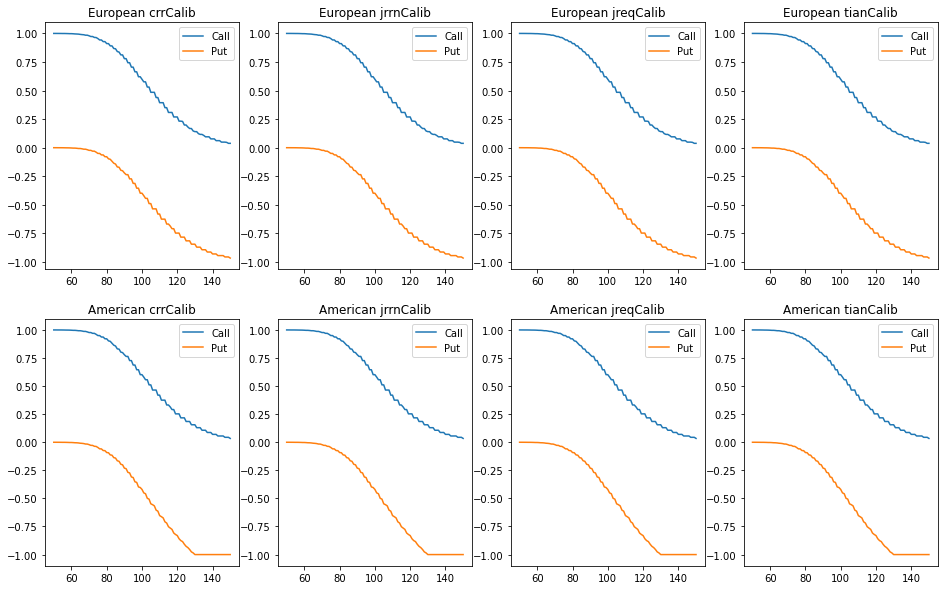

In [14]:
 # Delta
data = outcomes[GreekType.Delta]
fig, axs = plt.subplots(2, 4, figsize = (16,10))

for i in range(2): 
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call") 
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put") 
        axs[i, j].legend()

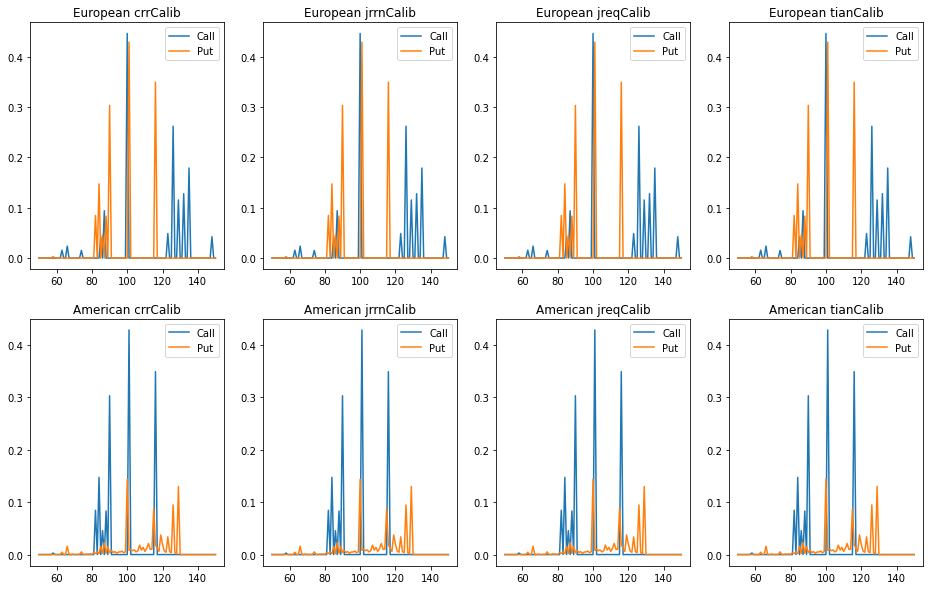

In [15]:
# Gamma
data = outcomes[GreekType.Gamma]
fig, axs = plt.subplots(2, 4, figsize = (16,10))
for i in range(2): 
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call") 
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put") 
        axs[i, j].legend()

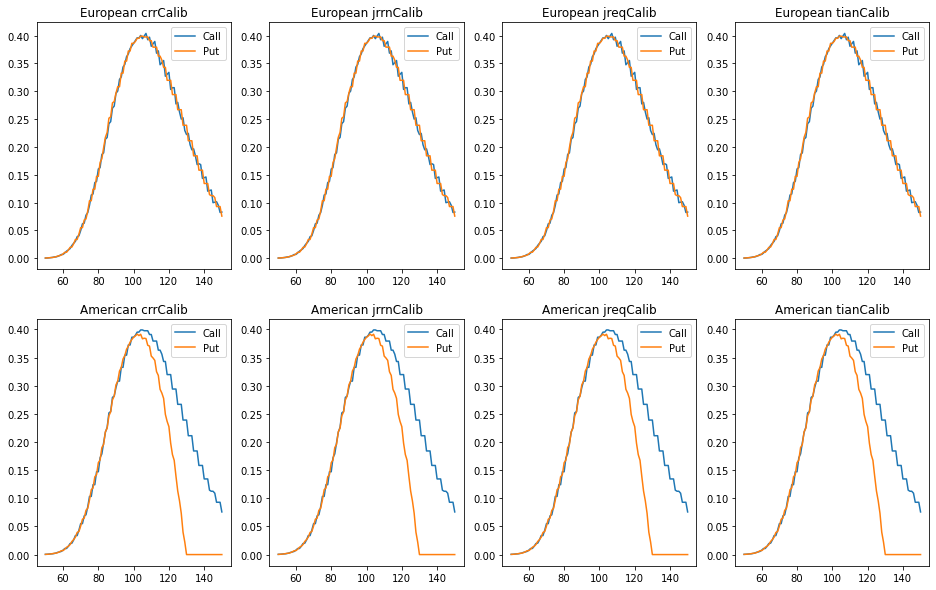

In [16]:
 # Vega
data = outcomes[GreekType.Vega]
fig, axs = plt.subplots(2, 4, figsize = (16,10))
for i in range(2): 
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call") 
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put") 
        axs[i, j].legend()

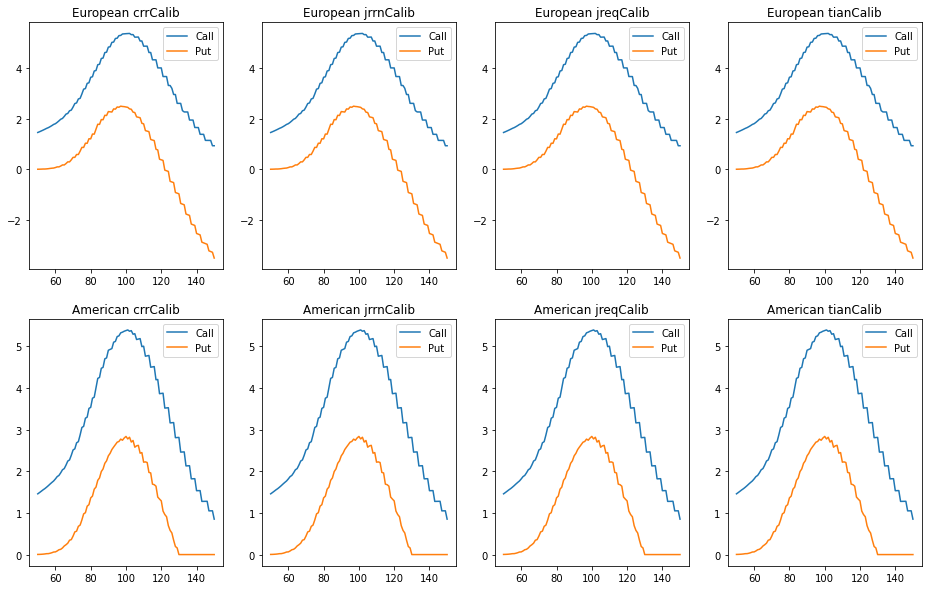

In [17]:
# Theta
data = outcomes[GreekType.Theta]
fig, axs = plt.subplots(2, 4, figsize = (16,10))
for i in range(2): 
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call") 
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put") 
        axs[i, j].legend()

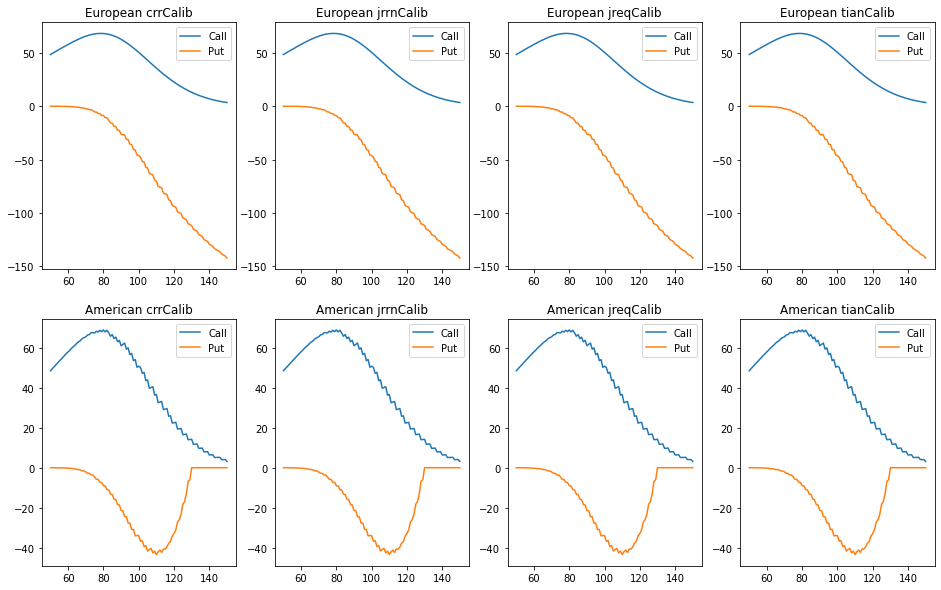

In [18]:
# Rho
data = outcomes[GreekType.Rho]
fig, axs = plt.subplots(2, 4, figsize = (16,10))
for i in range(2): 
    for j in range(4):
        title = cols[i*8+j].split()
        title = title[0]+' '+title[-1]
        axs[i, j].set_title(title)
        axs[i, j].plot(data[cols[i*8+j]],label="Call") 
        axs[i, j].plot(data[cols[i*8+j+4]],label="Put") 
        axs[i, j].legend()